In [ ]:
!PYTHONHASHSEED=0

# **Required libraries**








In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import random as python_random
import os
import pickle
from google.colab import drive
from sklearn.metrics import precision_score, f1_score, recall_score
from tabulate import tabulate



# **Data Loading**


In [ ]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
copyfile('gdrive/My Drive/Project FDL/MIR-WM811K.zip', 'MIRWM811K.zip')
# Extract files
zipp = zipfile.ZipFile('MIRWM811K.zip')
zipp.extractall()
with open("/content/MIR-WM811K/Python/WM811K.pkl","rb") as file:
  data=pickle.load(file)

In [ ]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   dieSize         811457 non-null  float64
 1   failureType     811457 non-null  object 
 2   lotName         811457 non-null  object 
 3   trainTestLabel  811457 non-null  object 
 4   waferIndex      811457 non-null  float64
 5   waferMap        811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


,dieSize,waferIndex
count,811457.000000,811457.000000
mean,1840.998585,12.961207
std,2254.987374,7.207489
min,3.000000,1.000000
25%,710.000000,7.000000
50%,953.000000,13.000000
75%,1902.000000,19.000000
max,48099.000000,25.000000


In [ ]:
data.head()


,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap
0,1683.0,none,lot1,Training,1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1683.0,none,lot1,Training,2.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1683.0,none,lot1,Training,3.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,1683.0,none,lot1,Training,4.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,1683.0,none,lot1,Training,5.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


# **Data Preprocessing**

We performed a cleaning of the dataset using the variable "trainTestLabel". Among the total number of rows, which is 811,457, there are 172,950 labeled images. However, the remaining images are associated with errors related to the acquisition process, as they have a failureType value of [0,0]. Therefore, we excluded these observations from the dataset.

In [ ]:
trainIdx=data[data['trainTestLabel']=='Training'].index
testIdx=data[data['trainTestLabel']=='Test'].index
#show each failure type
trainFailureType=data.loc[trainIdx,'failureType']
testFailureType=data.loc[testIdx,'failureType']
train_data=data.iloc[trainIdx,[1,5]]
test_data=data.iloc[testIdx,[1,5]]


/usr/local/lib/python3.10/dist-packages/pandas/core/ops/array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


The function below evaluate the size of each wafermap image.

In [ ]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
train_data['waferMapDim']=train_data.waferMap.apply(find_dim)
train_data.sample(5)

,failureType,waferMap,waferMapDim
232200,Edge-Ring,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(56, 62)"
45278,Edge-Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...","(39, 31)"
749258,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 2,...","(27, 25)"
699176,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...","(25, 27)"
698148,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...","(25, 27)"


The images in the dataset have different sizes, as can be observed from the results.

*Plot of each failureType*

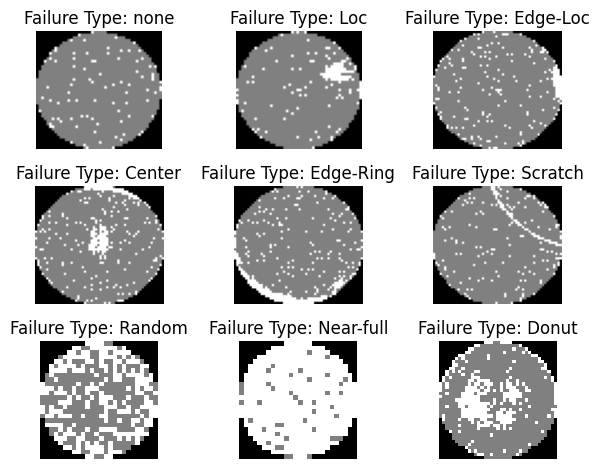

In [ ]:
unique_classes=train_data.failureType.unique()
num_rows=3
num_cols=3
for index, failure_type in enumerate(unique_classes):
    # Select the wafer map corresponding to the failure type
    wafer_map = train_data[train_data['failureType'] == failure_type]['waferMap'].iloc[0]

    # Calculate the subplot position
    position = index + 1

    # Create the subplot
    ax = plt.subplot(num_rows, num_cols, position)

    # Display the wafer map with a gray colormap
    ax.imshow(wafer_map, cmap='gray')

    # Set the title
    ax.set_title(f"Failure Type: {failure_type}")
    ax.axis('off')

#spacing between subplots
plt.tight_layout()
plt.show()


Although the dataset already has a division into training and test sets, we have decided to perform an additional split based on the variable trainTestLabel. This decision was made because the test set has a significantly larger number of observations compared to the training set.

In [ ]:
data_new=pd.concat([train_data,test_data])
from sklearn.model_selection import train_test_split
np.random.seed(20)
# Dividi il dataset iniziale in train set e test+validation set
features_train, features_test_val, labels_train, labels_test_val = train_test_split(data_new[["waferMap"]], data_new[["failureType"]], test_size=0.3, stratify=data_new[["failureType"]],random_state=10)

# Dividi il test+validation set in test set e validation set
features_test, features_val, labels_test, labels_val = train_test_split(features_test_val, labels_test_val, test_size=0.5, stratify=labels_test_val,random_state=10)


As we observed from the results of the previous function, the size of each image in terms of pixels varies for the different wafer maps. Therefore, it is necessary to resize them. We will compute the split between the various dimensions required to develop the different models.

In [ ]:
train_x=features_train['waferMap']
train_y=labels_train['failureType']
test_x=features_test['waferMap']
test_y=labels_test['failureType']
val_x=features_val["waferMap"]
val_y=labels_val["failureType"]

In [ ]:
print(train_x.shape)
print(test_x.shape)
print(val_x.shape)

(121065,)
(25942,)
(25943,)


Upon conducting a more detailed analysis of our sample, it becomes apparent that there exist 365 different image dimensions within it.

In [ ]:
data_new['waferMapDim']=data_new.waferMap.apply(find_dim)
data_new.waferMapDim.value_counts()

(25, 27)    18781
(26, 26)    14366
(30, 34)    12400
(29, 26)    11751
(27, 25)    10682
            ...  
(50, 68)        1
(29, 45)        1
(38, 41)        1
(75, 90)        1
(68, 75)        1
Name: waferMapDim, Length: 346, dtype: int64

We have modified the size of X_train, X_test, and X_val to have a fixed dimension of 32x32. For the images that did not have this dimension, a padding technique was applied to adjust their size.

The created function has been applied to the different sets of data, ensuring that all images now have a consistent dimension of 32x32

In [ ]:
def image_resizing(target_heigth,target_width,x_data):
  import cv2
  # Creazione del tensore dei dati di addestramento
  num_samples = x_data.shape[0]  # Sostituisci "your_data" con il nome della variabile che contiene i dati dei pixel
  x_return = np.zeros((num_samples, target_heigth, target_width, 1))  # Immagini in scala di grigi, quindi un solo canale
  for i, pixel_data in enumerate(x_data):
    #Caricamento dell'immagine utilizzando OpenCV
    image = np.array(pixel_data)

    # Ridimensionamento dell'immagine alla dimensione massima delle immagini
    max_dim = max(image.shape[0], image.shape[1])
    resized_image = cv2.resize(image, (int(target_width * image.shape[1] / max_dim), int(target_heigth * image.shape[0] / max_dim)))

    # Padding dell'immagine per raggiungere la dimensione di destinazione
    padded_image = np.pad(resized_image, ((0, target_heigth - resized_image.shape[0]), (0, target_width - resized_image.shape[1])), mode='constant')

    # Normalizzazione dei valori dei pixel nell'intervallo [0, 1]
    normalized_image = padded_image / 2  ##Ho modificato quest

    # Aggiunta di un'asse per il canale
    normalized_image = np.expand_dims(normalized_image, axis=-1)

    # Assegnazione dell'immagine al tensore dei dati di addestramento
    x_return[i] = normalized_image
  return x_return


In [ ]:
height=32
width=32
X_train=image_resizing(height,width,train_x)
X_test=image_resizing(height,width,test_x)
X_val=image_resizing(height,width,val_x)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_as_binary = LabelBinarizer()
y_train = label_as_binary.fit_transform(train_y)
y_test=label_as_binary.fit_transform(test_y)
y_val=label_as_binary.fit_transform(val_y)

Since the data are characterised by unbalanced classes, we decided to approach this problem in several ways. We used techniques to reduce this difference. In particular we have selected the Data Augmentation method, to introduce new images by appyling transformation to the existing ones. Secondly, we used another method: the SMOTHE technique to oversample the minority classes.
Additionally, in an unbalanced problem the Accuracy measure could not be an appropriate measure of evaluation of the results. For this reason we use also other measures as: Precision, F-measure and Recall.

In [ ]:
# Creo una lista contenente l'ordine delle classi
conto = y_train.sum(axis=0)
nomi=[]
for i in range(9):
  nomi.append(train_y.value_counts().index[np.where(conto == train_y.value_counts()[i])[0].item()])

In [ ]:
##Creo una funzione che stampa una tabella
def table_score(nomi,precision,f1,recall):
  table = []
  for class_idx in range(len(nomi)):
    table.append([nomi[class_idx], precision[class_idx] * 100,f1[class_idx]*100,recall[class_idx]*100])
  # Generate and print the table
  table_headers = ["Classe", "Precisione","F1_score","Recall"]
  table_f = tabulate(table, headers=table_headers)
  return table_f

# **Setting the Seed and Neural Network Architecture**

In [ ]:
seed_value = 10
np.random.seed(seed_value)
python_random.seed(seed_value)
tf.random.set_seed(seed_value)

The provided code defines a more complex model architecture using the Sequential API from TensorFlow's Keras. Here is a summary of the code:

* The input shape is defined as (32, 32, 1), indicating that the model expects input images with dimensions of 32x32 pixels and a single channel (grayscale).

* Several layers are then added to the model:

 * Conv2D layer with 32 filters, a kernel size of 3x3, and 'same' padding.
BatchNormalization layer to normalize the activations of the previous layer.
Activation layer with the ReLU activation function.

 * MaxPooling2D layer with a pool size of 3x3 and 'same' padding.

 * Additional Conv2D and MaxPooling2D layers are repeated with 64 filters and 128 filters, respectively, following the same structure as the first Conv2D layer.

 * Finally, a GlobalMaxPooling2D layer is added to convert the 2D feature map into a 1D vector.

 * The output layer is defined as a Dense layer with 9 units and a softmax activation function, indicating a multiclass classification problem.



In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Conv2DTranspose, Input

# the input shape
inputs = keras.Input((32,32,1))

x = inputs
x = keras.layers.Conv2D(32, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(9, activation="softmax")(x)

# **First Model**

In [ ]:
net_first = keras.Model(inputs, outputs)
# Compile the model for training
net_first.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy',tf.keras.metrics.Precision()])
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint_callback_first = keras.callbacks.ModelCheckpoint(filepath='gdrive/My Drive/Project FDL/First_model/weigth.{epoch:02d}.h5', save_weights_only=True, save_freq='epoch')
#Model Training
history_first = net_first.fit(X_train, y_train, epochs=20, validation_data=(X_val,y_val), callbacks=[callback,checkpoint_callback_first], batch_size=32, shuffle=True)
with open('gdrive/My Drive/Project FDL/First_model/history_first.pickle', 'wb') as file:
    pickle.dump(history_first, file)
net_first.save('gdrive/My Drive/Project FDL/First_model/net_first')

Epoch 1/20
3784/3784 [==============================] - 38s 7ms/step - loss: 0.2071 - accuracy: 0.9434 - precision: 0.9521 - val_loss: 0.1707 - val_accuracy: 0.9511 - val_precision: 0.9569
Epoch 2/20
3784/3784 [==============================] - 24s 6ms/step - loss: 0.1545 - accuracy: 0.9550 - precision: 0.9617 - val_loss: 0.1959 - val_accuracy: 0.9448 - val_precision: 0.9543
Epoch 3/20
3784/3784 [==============================] - 28s 7ms/step - loss: 0.1377 - accuracy: 0.9593 - precision: 0.9655 - val_loss: 0.1391 - val_accuracy: 0.9593 - val_precision: 0.9650
Epoch 4/20
3784/3784 [==============================] - 27s 7ms/step - loss: 0.1270 - accuracy: 0.9618 - precision: 0.9672 - val_loss: 0.1608 - val_accuracy: 0.9534 - val_precision: 0.9628
Epoch 5/20
3784/3784 [==============================] - 27s 7ms/step - loss: 0.1178 - accuracy: 0.9640 - precision: 0.9690 - val_loss: 0.1468 - val_accuracy: 0.9564 - val_precision: 0.9622
Epoch 6/20
3784/3784 [==============================] -

Due to the high computational complexity of the model, which entails lengthy processing times, a function for epoch saving has been implemented. The following code loads the weights from the last completed epoch in case of a model estimation interruption.

In [ ]:
#model.load_weights('gdrive/My Drive/Project FDL/First_model/weigth.{epoch:02d}.h5')  # Sostituisci <epoch> con il numero dell'ultima epoca completata
#num_epochs=  #deve essere uguale all'ultima epoch completata
#epo=    #deve essere uguale all'epoch dalla quale voglio riprendere l'addestramento
#model.fit(x_train, y_train, initial_epoch= epo, epochs=num_epochs, callbacks=[callback,checkpoint_callback_first])

The following code has been implemented to load the computed model and avoid
its re-calculation

In [ ]:
net_first=keras.models.load_model('gdrive/My Drive/Project FDL/First_model/net_first')
with open('gdrive/My Drive/Project FDL/First_model/history_first.pickle', 'rb') as file:
    history_first = pickle.load(file)

In [ ]:
net_first.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496 

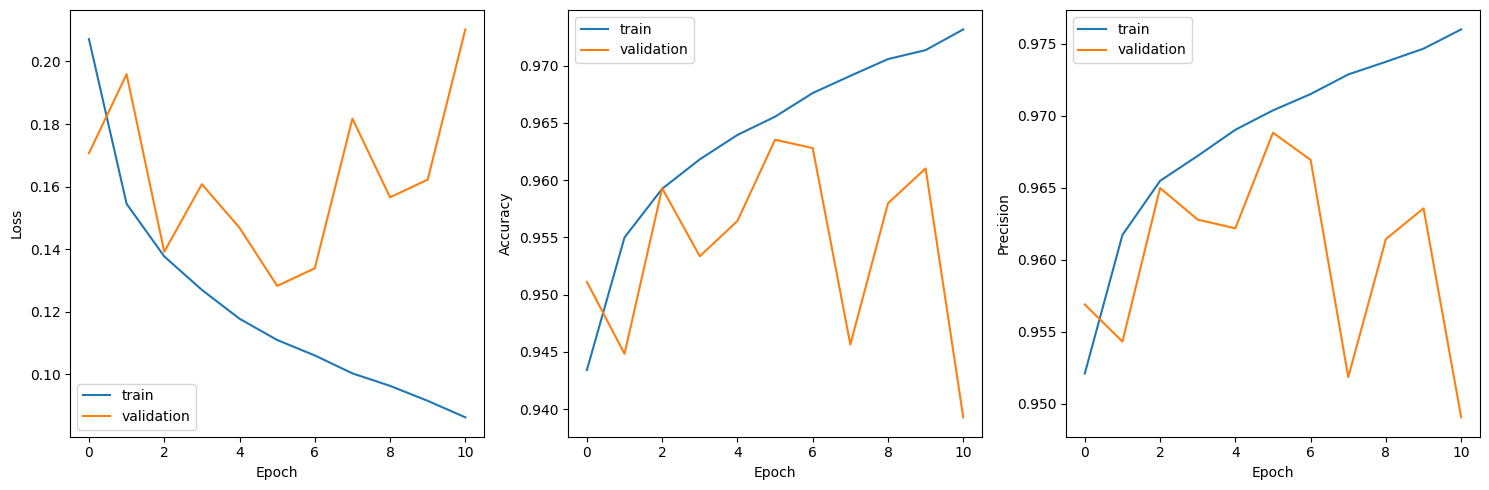

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Crea una griglia di subplot 1x3

# Loss
axs[0].plot(history_first.history['loss'])
axs[0].plot(history_first.history['val_loss'])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend(['train', 'validation'])

# Accuracy
axs[1].plot(history_first.history['accuracy'])
axs[1].plot(history_first.history['val_accuracy'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['train', 'validation'])

# Precision
axs[2].plot(history_first.history['precision'])
axs[2].plot(history_first.history['val_precision'])
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Precision')
axs[2].legend(['train', 'validation'])

plt.tight_layout()  # Per evitare sovrapposizioni di etichette o assi
plt.show()

The executed code utilizes the evaluate method of the Keras model to assess its performance using a test dataset

In [ ]:
net_first.evaluate(X_test,y_test)

811/811 [==============================] - 3s 3ms/step - loss: 0.1949 - accuracy: 0.9432 - precision: 0.9530


[0.19487716257572174, 0.9432194828987122, 0.9530298709869385]

The test set is used for generating predictions.

In [ ]:
y_pred_first=net_first.predict(X_test)

811/811 [==============================] - 2s 2ms/step


In the provided Python code, precision scores for each class have been calculated

In [ ]:
# Calcola la precisione, f1_Score and  per ogni classe

precision_per_classe_first = precision_score(y_test.argmax(axis=1), y_pred_first.argmax(axis=1), average=None)
f1_score_classe_first= f1_score(y_test.argmax(axis=1), y_pred_first.argmax(axis=1), average=None)
recall_classe_first = recall_score(y_test.argmax(axis=1), y_pred_first.argmax(axis=1), average=None)

print(table_score(nomi,precision_per_classe_first,f1_score_classe_first,recall_classe_first))

Classe       Precisione    F1_score    Recall
---------  ------------  ----------  --------
Near-full       81.8052     85.0969   88.6646
Center          44.0678     60        93.9759
Edge-Loc        58.1677     69.5607   86.5039
none            95.6583     94.8611   94.0771
Loc             64.1949     59.9407   56.2152
Donut          100          35.7143   21.7391
Random          87.931      82.9268   78.4615
Edge-Ring       22.1354     30.1954   47.486
Scratch         98.9816     97.5997   96.2558


Looking at the precision, F1 score, and recall for each class, we can observe variations in performance across different categories. Classes like "None", "Scratch" and "Donut" exhibit high precision, F1 scores, and recall, indicating strong classification performance. On the other hand, classes such as "Edge-Ring" and center have relatively lower scores, suggesting room for improvement in their classification accuracy.
In detail, it can be observed that the model's performance for the "Center" label is characterized by low precision, moderate F1-score, and high recall. This means that while the model can identify a significant number of "Center" instances (high recall), it also has a relatively high rate of false positives (low precision).

The macro-averaged precision, F1 score, and recall are metrics commonly used to evaluate the performance of a multiclass classification model.

Precision measures the proportion of correctly predicted positive instances out of the total instances predicted as positive. It indicates the model's ability to avoid false positive predictions. A higher precision value suggests that the model has a lower rate of falsely classifying negative instances as positive.

The F1 score is a harmonic mean of precision and recall. It provides a balanced measure of a model's performance by considering both precision and recall.

Recall, also known as sensitivity or true positive rate, measures the proportion of correctly predicted positive instances out of the total actual positive instances. It indicates the model's ability to identify all positive instances. A higher recall value suggests that the model has a lower rate of falsely classifying positive instances as negative.

In [ ]:
print(precision_score(y_test.argmax(axis=1), y_pred_first.argmax(axis=1), average="macro"),
f1_score(y_test.argmax(axis=1), y_pred_first.argmax(axis=1), average="macro"),
recall_score(y_test.argmax(axis=1), y_pred_first.argmax(axis=1), average="macro"))

0.7254909901249423 0.6843283605789674 0.7370879691860202


The model chosen achieved the following results for precision, F1 score, and recall: 0.725, 0.684, and 0.737, respectively.

# **Second Model**

In [ ]:
net_second = keras.Model(inputs, outputs)
# Compile the model for training
net_second.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy',tf.keras.metrics.Precision()])
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint_callback_second = keras.callbacks.ModelCheckpoint(filepath='gdrive/My Drive/Project FDL/Second_model/weigth.{epoch:02d}.h5', save_weights_only=True, save_freq='epoch')
#Model Training
history_second = net_second.fit(X_train,y_train, epochs=20, validation_data=(X_val,y_val), batch_size=32, callbacks=[callback,checkpoint_callback_second], shuffle=True)
with open('gdrive/My Drive/Project FDL/Second_model/history_second.pickle', 'wb') as file:
    pickle.dump(history_second, file)
net_second.save('gdrive/My Drive/Project FDL/Second_model/net_second')


Epoch 1/20
3784/3784 [==============================] - 28s 7ms/step - loss: 0.0568 - accuracy: 0.9823 - precision_1: 0.9844 - val_loss: 0.1282 - val_accuracy: 0.9664 - val_precision_1: 0.9687
Epoch 2/20
3784/3784 [==============================] - 25s 7ms/step - loss: 0.0499 - accuracy: 0.9842 - precision_1: 0.9859 - val_loss: 0.1311 - val_accuracy: 0.9658 - val_precision_1: 0.9680
Epoch 3/20
3784/3784 [==============================] - 25s 7ms/step - loss: 0.0468 - accuracy: 0.9855 - precision_1: 0.9871 - val_loss: 0.1342 - val_accuracy: 0.9654 - val_precision_1: 0.9675
Epoch 4/20
3784/3784 [==============================] - 27s 7ms/step - loss: 0.0442 - accuracy: 0.9867 - precision_1: 0.9880 - val_loss: 0.1376 - val_accuracy: 0.9653 - val_precision_1: 0.9671
Epoch 5/20
3784/3784 [==============================] - 25s 6ms/step - loss: 0.0420 - accuracy: 0.9869 - precision_1: 0.9884 - val_loss: 0.1440 - val_accuracy: 0.9625 - val_precision_1: 0.9646
Epoch 6/20
3784/3784 [=============

In [ ]:
#model.load_weights('gdrive/My Drive/Project FDL/Second_model/weigth.{epoch:02d}.h5')  # Sostituisci <epoch> con il numero dell'ultima epoca completata
#num_epochs=  #deve essere uguale all'ultima epoch completata
#epo=    #deve essere uguale all'epoch dalla quale voglio riprendere l'addestramento
#model.fit(x_train, y_train, initial_epoch= epo, epochs=num_epochs, callbacks=[callback,checkpoint_callback_second])

In [ ]:
net_second=keras.models.load_model('gdrive/My Drive/Project FDL/Second_model/net_second')
with open('gdrive/My Drive/Project FDL/Second_model/history_second.pickle', 'rb') as file:
    history_second = pickle.load(file)

In [ ]:
net_second.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        1849

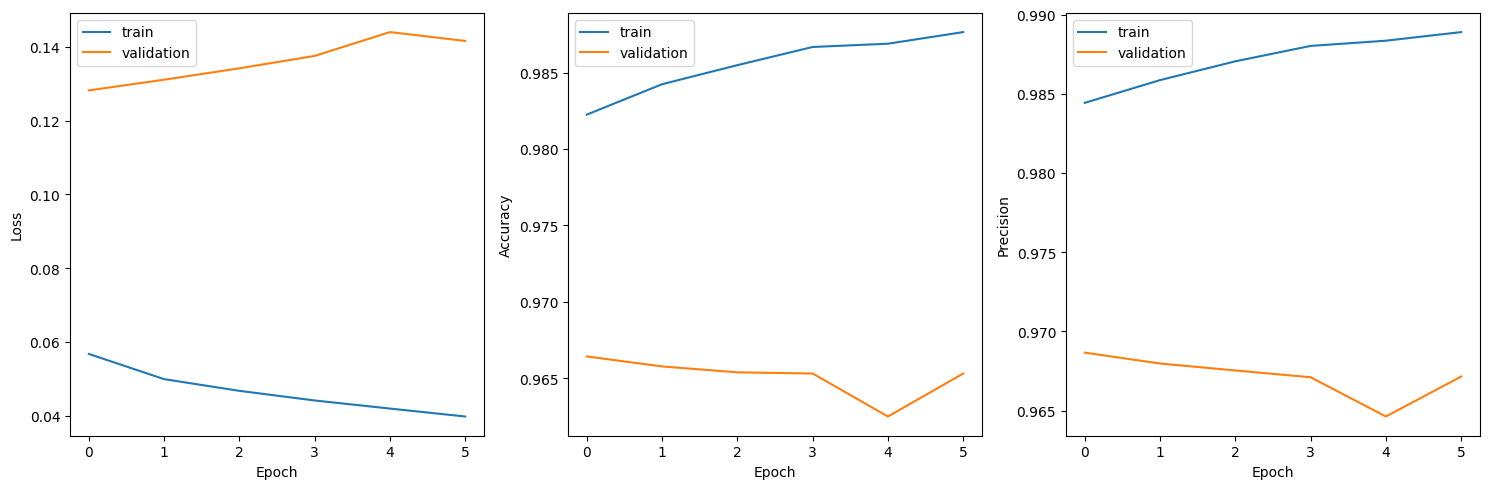

In [ ]:
fig, axs_second = plt.subplots(1, 3, figsize=(15, 5))  # Crea una griglia di subplot 1x3

# Loss
axs_second[0].plot(history_second.history['loss'])
axs_second[0].plot(history_second.history['val_loss'])
axs_second[0].set_xlabel('Epoch')
axs_second[0].set_ylabel('Loss')
axs_second[0].legend(['train', 'validation'])

# Accuracy
axs_second[1].plot(history_second.history['accuracy'])
axs_second[1].plot(history_second.history['val_accuracy'])
axs_second[1].set_xlabel('Epoch')
axs_second[1].set_ylabel('Accuracy')
axs_second[1].legend(['train', 'validation'])

# Precision
axs_second[2].plot(history_second.history['precision_1'])
axs_second[2].plot(history_second.history['val_precision_1'])
axs_second[2].set_xlabel('Epoch')
axs_second[2].set_ylabel('Precision')
axs_second[2].legend(['train', 'validation'])

plt.tight_layout()  # Per evitare sovrapposizioni di etichette o assi
plt.show()

The executed code utilizes the evaluate method of the Keras model to assess its performance using a test dataset.

In [ ]:
net_second.evaluate(X_test,y_test)

811/811 [==============================] - 3s 3ms/step - loss: 0.1269 - accuracy: 0.9666 - precision_1: 0.9685


[0.12694430351257324, 0.9666178226470947, 0.968525230884552]

The first value, [0.1269], represents the calculated loss of the model during the evaluation on the test data. The loss measures the discrepancy between the model's predictions and the true labels.

The second value, [0.966], corresponds to the accuracy achieved by the model during the evaluation. Accuracy indicates the percentage of correctly classified examples out of the total test samples.



The test set is used for generating predictions.

In [ ]:
y_pred_second=net_second.predict(X_test)

811/811 [==============================] - 2s 2ms/step


The precision, F1 score, and recall per class are computed on the test set.

In [ ]:
# Calcola la precisione per ogni classe
precision_per_classe_second = precision_score(y_test.argmax(axis=1), y_pred_second.argmax(axis=1), average=None)
f1_score_classe_second= f1_score(y_test.argmax(axis=1), y_pred_second.argmax(axis=1), average=None)
recall_classe_second = recall_score(y_test.argmax(axis=1), y_pred_second.argmax(axis=1), average=None)

print(table_score(nomi,precision_per_classe_second,f1_score_classe_second,recall_classe_second))

Classe       Precisione    F1_score    Recall
---------  ------------  ----------  --------
Near-full       90.6103     90.2572   89.9068
Center          81.7073     81.2121   80.7229
Edge-Loc        78.9835     76.3612   73.9075
none            97.3296     96.3478   95.3857
Loc             69.5733     69.5733   69.5733
Donut           95.6522     95.6522   95.6522
Random          90.9091     87.6494   84.6154
Edge-Ring       53.125      44.2997   37.9888
Scratch         98.3647     98.6861   99.0097


In [ ]:
print(precision_score(y_test.argmax(axis=1), y_pred_second.argmax(axis=1), average="macro"),
f1_score(y_test.argmax(axis=1), y_pred_second.argmax(axis=1), average = "macro"),
recall_score(y_test.argmax(axis=1), y_pred_second.argmax(axis=1), average="macro"))

0.8402833363002233 0.8222656123775963 0.807513555710072


The model chosen achieved the following results for precision, F1 score, and recall: 0.8412, 0.8181, and 0.800, respectively.

# **Data Augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crea un'istanza di ImageDataGenerator con le trasformazioni desiderate
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2)

# Adatta il generatore ai dati di addestramento
datagen.fit(X_train)

# Genera nuove istanze fino a raggiungere il numero desiderato per ogni classe
generated_instances = []
l_duplicated=[]
class_labels=["Edge-Ring","Edge-Loc","Center","Loc","Scratch","Random","Donut","Near-full"]
class_variable=[]

for class_label in class_labels:
   count=0
   indices = np.where(train_y ==class_label)
   X_class = X_train[indices]  # ottieni le istanze di una specifica classe
   num_new_instances=2  # numero di nuove istanze da generare

   for image in X_class:
    # Aggiungi la dimensione dei campioni all'array
      new_instance = datagen.flow(np.expand_dims(image, axis=0), batch_size=1, shuffle=False).__next__()
      generated_instances.append(new_instance)
      l_duplicated.append(class_label)
X_train_aug = np.concatenate([X_train] + generated_instances, axis=0)
y_train_aug = np.concatenate((np.array(train_y),np.array(l_duplicated)) , axis=0)


#I will keep the code commented to save the new x_train and y_train to avoid overwriting the data

# Save generated_instances
with open('gdrive/My Drive/Project FDL/Aug_model/generated_instance.pkl', 'wb') as file:
    pickle.dump(generated_instances, file)

# Save generated_label
with open('gdrive/My Drive/Project FDL/Aug_model/generated_label.pkl', 'wb') as file:
    pickle.dump(np.array(l_duplicated), file)

# Save X_train_augmented
with open('gdrive/My Drive/Project FDL/Aug_model/X_train_augmented.pkl', 'wb') as file:
    pickle.dump(X_train_aug, file)

# Save y_train_augmented
with open('gdrive/My Drive/Project FDL/Aug_model/y_train_augmented.pkl', 'wb') as file:
    pickle.dump(y_train_aug, file)


In [ ]:
# Load generated_instance
with open('gdrive/My Drive/Project FDL/Aug_model/generated_instance.pkl', 'rb') as file:
    generated_instance = pickle.load(file)

# Load generated_label
with open('gdrive/My Drive/Project FDL/Aug_model/generated_label.pkl', 'rb') as file:
    generated_label = pickle.load(file)

# Load y_train_augmented
with open('gdrive/My Drive/Project FDL/Aug_model/X_train_augmented.pkl', 'rb') as file:
    X_train_augmented = pickle.load(file)

# Load y_train_augmented
with open('gdrive/My Drive/Project FDL/Aug_model/y_train_augmented.pkl', 'rb') as file:
    y_train_augmented = pickle.load(file)


"Each class, except for the majority class 'none', has been duplicated to increase its representation during data augmentation."

"The training set is compared before and after applying data augmentation."

In [ ]:
print(X_train.shape,X_train_augmented.shape)

(121065, 32, 32, 1) (138928, 32, 32, 1)


"The number of classes is compared before and after data augmentation."

In [ ]:
print(train_y.value_counts(),"\n\n",pd.Series(y_train_augmented).value_counts())

none         103202
Edge-Ring      6776
Edge-Loc       3632
Center         3006
Loc            2515
Scratch         835
Random          606
Donut           389
Near-full       104
Name: failureType, dtype: int64 

 none         103202
Edge-Ring     13552
Edge-Loc       7264
Center         6012
Loc            5030
Scratch        1670
Random         1212
Donut           778
Near-full       208
dtype: int64



The generated observations with data augmentation are visually displayed.

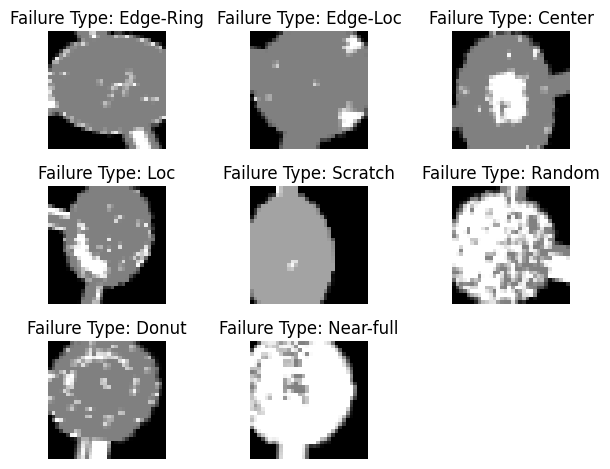

In [ ]:
num_rows = 3
num_cols = 3
generated_instance = np.array(generated_instance)
train_labels=pd.Series(generated_label)
# Assumendo che il tensore 4D si chiami 'image_tensor'
unique_classes = train_labels.unique()  # Sostituisci con il tuo array di etichette



for index, failure_type in enumerate(unique_classes):
    # Seleziona le immagini corrispondenti al tipo di fallimento

    images = generated_instance[train_labels==failure_type][:2]

    # Calcola la posizione del subplot
    position = index + 1

    # Crea il subplot
    ax = plt.subplot(num_rows, num_cols, position)

    # Mostra le immagini
    for i, image in enumerate(images):
        ax.imshow(image.reshape(32,32), cmap='gray')

        # Calcola la posizione del sottoplot all'interno del subplot principale
        subposition = i + 1

        # Imposta il titolo
        ax.set_title(f"Failure Type: {failure_type}")
        ax.axis('off')

# Spaziatura tra i sottoplot
plt.tight_layout()
plt.show()

In [ ]:
y_train_augme=label_as_binary.fit_transform(y_train_augmented)


"The model is estimated with data augmentation."

In [ ]:
net_aug = keras.Model(inputs, outputs)
# Compile the model for training
net_aug.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy',tf.keras.metrics.Precision()])
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint_callback_aug = keras.callbacks.ModelCheckpoint(filepath='gdrive/My Drive/Project FDL/Aug_model/weigth.{epoch:02d}.h5', save_weights_only=True, save_freq='epoch')

#Model Training
history_aug = net_aug.fit(X_train_augmented,y_train_augme, epochs=20, validation_data=(X_val,y_val), callbacks=[callback,checkpoint_callback_aug], batch_size=32, shuffle=True)
with open('gdrive/My Drive/Project FDL/Aug_model/history_aug.pickle', 'wb') as file:
    pickle.dump(history_aug, file)
net_aug.save('gdrive/My Drive/Project FDL/Aug_model/net_aug')

Epoch 1/20
4342/4342 [==============================] - 50s 8ms/step - loss: 0.2543 - accuracy: 0.9200 - precision: 0.9404 - val_loss: 0.4637 - val_accuracy: 0.8678 - val_precision: 0.9024
Epoch 2/20
4342/4342 [==============================] - 28s 6ms/step - loss: 0.1903 - accuracy: 0.9380 - precision: 0.9520 - val_loss: 0.2477 - val_accuracy: 0.9282 - val_precision: 0.9486
Epoch 3/20
4342/4342 [==============================] - 29s 7ms/step - loss: 0.1680 - accuracy: 0.9450 - precision: 0.9566 - val_loss: 0.1452 - val_accuracy: 0.9581 - val_precision: 0.9664
Epoch 4/20
4342/4342 [==============================] - 29s 7ms/step - loss: 0.1518 - accuracy: 0.9500 - precision: 0.9600 - val_loss: 0.1503 - val_accuracy: 0.9545 - val_precision: 0.9602
Epoch 5/20
4342/4342 [==============================] - 28s 7ms/step - loss: 0.1374 - accuracy: 0.9541 - precision: 0.9628 - val_loss: 0.1298 - val_accuracy: 0.9615 - val_precision: 0.9662
Epoch 6/20
4342/4342 [==============================] -

In [ ]:
#model.load_weights('gdrive/My Drive/Project FDL/Aug_model/weigth.{epoch:02d}.h5')  # Replace <epoch> with the number of the last completed epoch
#num_epochs=  #It must be equal to the last completed epoch
#epo=    #It must be equal to the epoch from which I want to resume training
#model.fit(x_train, y_train, initial_epoch= epo, epochs=num_epochs, callbacks=[callback,checkpoint_callback_aug])

In [ ]:
net_aug=keras.models.load_model('gdrive/My Drive/Project FDL/Aug_model/net_aug')
with open('gdrive/My Drive/Project FDL/Aug_model/history_aug.pickle', 'rb') as file:
    history_aug = pickle.load(file)

In [ ]:
net_aug.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496 

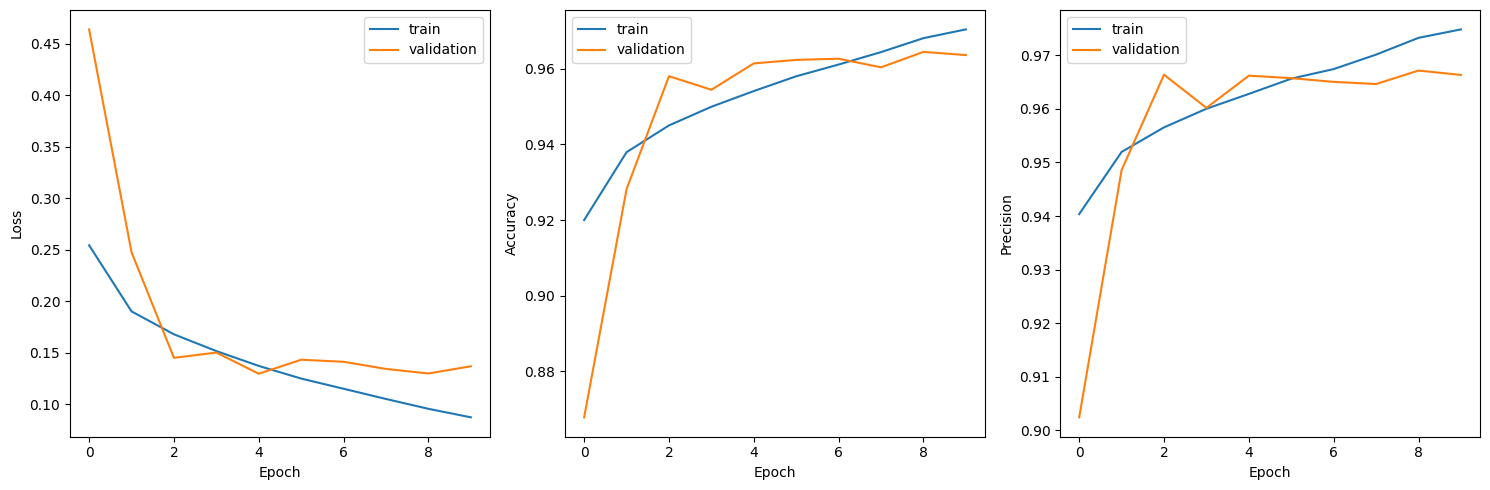

In [ ]:
fig, axs_aug = plt.subplots(1, 3, figsize=(15, 5))

# Loss
axs_aug[0].plot(history_aug.history['loss'])
axs_aug[0].plot(history_aug.history['val_loss'])
axs_aug[0].set_xlabel('Epoch')
axs_aug[0].set_ylabel('Loss')
axs_aug[0].legend(['train', 'validation'])

# Accuracy
axs_aug[1].plot(history_aug.history['accuracy'])
axs_aug[1].plot(history_aug.history['val_accuracy'])
axs_aug[1].set_xlabel('Epoch')
axs_aug[1].set_ylabel('Accuracy')
axs_aug[1].legend(['train', 'validation'])

# Precision
axs_aug[2].plot(history_aug.history['precision'])
axs_aug[2].plot(history_aug.history['val_precision'])
axs_aug[2].set_xlabel('Epoch')
axs_aug[2].set_ylabel('Precision')
axs_aug[2].legend(['train', 'validation'])

plt.tight_layout()
plt.show()

The executed code utilizes the evaluate method of the Keras model to assess its performance using a test dataset.

In [ ]:
net_aug.evaluate(X_test,y_test)

811/811 [==============================] - 4s 4ms/step - loss: 0.1205 - accuracy: 0.9670 - precision: 0.9700


[0.120501309633255, 0.9669647812843323, 0.9700174331665039]

The model is being employed to generate predictions on the test set

In [ ]:
y_pred_aug=net_aug.predict(X_test)

811/811 [==============================] - 2s 2ms/step


I am computing the precision, f1 and recall for each class.

In [ ]:
# I am computing the precision for each class.
precision_per_classe_aug = precision_score(y_test.argmax(axis=1), y_pred_aug.argmax(axis=1), average=None)
f1_score_classe_aug= f1_score(y_test.argmax(axis=1), y_pred_aug.argmax(axis=1), average=None)
recall_classe_aug = recall_score(y_test.argmax(axis=1), y_pred_aug.argmax(axis=1), average=None)

print(table_score(nomi,precision_per_classe_aug, f1_score_classe_aug, recall_classe_aug))

Classe       Precisione    F1_score    Recall
---------  ------------  ----------  --------
Near-full       89.5385     89.9536   90.3727
Center          81.7204     86.3636   91.5663
Edge-Loc        87.9675     77.6741   69.5373
none            96.6805     96.4803   96.281
Loc             81.1705     68.4549   59.1837
Donut          100          95.4545   91.3043
Random          86.5672     87.8788   89.2308
Edge-Ring       47.2973     42.8135   39.1061
Scratch         97.8612     98.5816   99.3127


In [ ]:
print(precision_score(y_test.argmax(axis=1), y_pred_aug.argmax(axis=1), average="macro"),
f1_score(y_test.argmax(axis=1), y_pred_aug.argmax(axis=1), average="macro"),
recall_score(y_test.argmax(axis=1), y_pred_aug.argmax(axis=1), average="macro"))

0.8542255193088448 0.8262832993122725 0.8065497678482116


The model chosen achieved the following results for precision, F1 score, and recall: 0.86, 0.819 e 0.787, respectively.

# **Smote**

We create a dictionary containing the class and the desired number of observations for that specific label.

In [ ]:
dizio=train_y.value_counts().to_dict()
del dizio['none']
del dizio['Edge-Ring']
for i in dizio:
  dizio[i]=dizio[i]*2
print(dizio)

{'Edge-Loc': 7264, 'Center': 6012, 'Loc': 5030, 'Scratch': 1670, 'Random': 1212, 'Donut': 778, 'Near-full': 208}


The SMOTE technique is employed to address class imbalance by generating synthetic samples. In this approach, the original 4D tensor representing images is transformed into a 2D format to apply SMOTE. By oversampling the minority classes, synthetic images are created. Finally, these synthetic images are converted back into the original 4D tensor format. This technique helps to increase the representation of minority classes and improve the overall performance of the model in handling class imbalance.

In [ ]:
from imblearn.over_sampling import SMOTE
# Reshape x_train into 2D format
n_samples, img_length, img_width, channels = X_train.shape
x_train_2d = X_train.reshape((n_samples, img_length * img_width * channels))

# Apply SMOTE
sm = SMOTE(sampling_strategy=dizio,random_state=42)
x_res, train_y_smo = sm.fit_resample(x_train_2d, train_y)

# Converto x_res into a 4d format
x_train_smo = x_res.reshape((x_res.shape[0], img_length, img_width, channels))

#I will keep the code commented to save the new x_train and y_train to avoid overwriting the data

# Save x_train_smo
#with open('gdrive/My Drive/Project FDL/Smote_model/X_train_smote.pkl', 'wb') as file:
#    pickle.dump(x_train_smo, file)

# Save y_train_smo
#with open('gdrive/My Drive/Project FDL/Smote_model/y_train_smote.pkl', 'wb') as file:
#    pickle.dump(train_y_smo, file)

In [ ]:
# Load y_train_augmented
with open('gdrive/My Drive/Project FDL/Smote_model/X_train_smote.pkl', 'rb') as file:
    x_train_smote = pickle.load(file)

# Load y_train_augmented
with open('gdrive/My Drive/Project FDL/Smote_model/y_train_smote.pkl', 'rb') as file:
    train_y_smote = pickle.load(file)

I compare the dimensions of the X_train tensor before and after utilizing the SMOTE technique. By doing so, I can observe the impact of SMOTE on the size of the training data. Before applying SMOTE, the X_train tensor has its original dimensions. However, after applying SMOTE, the dimensions of X_train may change due to the generation of synthetic samples. This allows me to assess the effect of SMOTE on the dataset and understand the potential increase in data size resulting from the technique.

In [ ]:
print(X_train.shape,x_train_smote.shape)

(121065, 32, 32, 1) (132152, 32, 32, 1)


After evaluating the size transformation of the X_train tensor using the SMOTE technique, I proceed to analyze the distribution of observations across different classes.

In [ ]:
print(train_y.value_counts(),'\n\n',train_y_smote.value_counts())

none         103202
Edge-Ring      6776
Edge-Loc       3632
Center         3006
Loc            2515
Scratch         835
Random          606
Donut           389
Near-full       104
Name: failureType, dtype: int64 

 none         103202
Edge-Loc       7264
Edge-Ring      6776
Center         6012
Loc            5030
Scratch        1670
Random         1212
Donut           778
Near-full       208
Name: failureType, dtype: int64


In [ ]:
y_train_smote=label_as_binary.fit_transform(train_y_smote)

In [ ]:
net_smote = keras.Model(inputs, outputs)
# Compile the model for training
net_smote.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy',tf.keras.metrics.Precision()])
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath='gdrive/My Drive/Project FDL/Smote_model/weigth.{epoch:02d}.h5', save_weights_only=True, save_freq='epoch')

#Model Training
history_smote = net_smote.fit(x_train_smote,y_train_smote, epochs=20, validation_data=(X_val,y_val), callbacks=[callback,checkpoint_callback], batch_size=32, shuffle=True)
with open('gdrive/My Drive/Project FDL/Smote_model/history_smote.pickle', 'wb') as file:
    pickle.dump(history_smote, file)
net_smote.save('gdrive/My Drive/Project FDL/Smote_model/net_smote')

Epoch 1/20
4130/4130 [==============================] - 313s 75ms/step - loss: 0.2313 - accuracy: 0.9305 - precision: 0.9444 - val_loss: 0.4542 - val_accuracy: 0.8694 - val_precision: 0.9140
Epoch 2/20
4130/4130 [==============================] - 289s 70ms/step - loss: 0.1624 - accuracy: 0.9489 - precision: 0.9576 - val_loss: 1.1441 - val_accuracy: 0.6276 - val_precision: 0.6825
Epoch 3/20
4130/4130 [==============================] - 294s 71ms/step - loss: 0.1371 - accuracy: 0.9565 - precision: 0.9635 - val_loss: 0.1661 - val_accuracy: 0.9579 - val_precision: 0.9610
Epoch 4/20
4130/4130 [==============================] - 293s 71ms/step - loss: 0.1173 - accuracy: 0.9623 - precision: 0.9675 - val_loss: 0.1462 - val_accuracy: 0.9575 - val_precision: 0.9617
Epoch 5/20
4130/4130 [==============================] - 293s 71ms/step - loss: 0.1002 - accuracy: 0.9675 - precision: 0.9712 - val_loss: 0.1443 - val_accuracy: 0.9592 - val_precision: 0.9645
Epoch 6/20
4130/4130 [=======================

In [ ]:
#model.load_weights('gdrive/My Drive/Project FDL/Smote_model/weigth.{epoch:02d}.h5')  # Sostituisci <epoch> con il numero dell'ultima epoca completata
#num_epochs=  #deve essere uguale all'ultima epoch completata
#epo=    #deve essere uguale all'epoch dalla quale voglio riprendere l'addestramento
#model.fit(x_train, y_train, initial_epoch= epo, epochs=num_epochs, callbacks=[callback,checkpoint_callback_smote])

In [ ]:
net_smote=keras.models.load_model('gdrive/My Drive/Project FDL/Smote_model/net_smote')
with open('gdrive/My Drive/Project FDL/Smote_model/history_smote.pickle', 'rb') as file:
    history_smote = pickle.load(file)

In [ ]:
net_smote.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496 

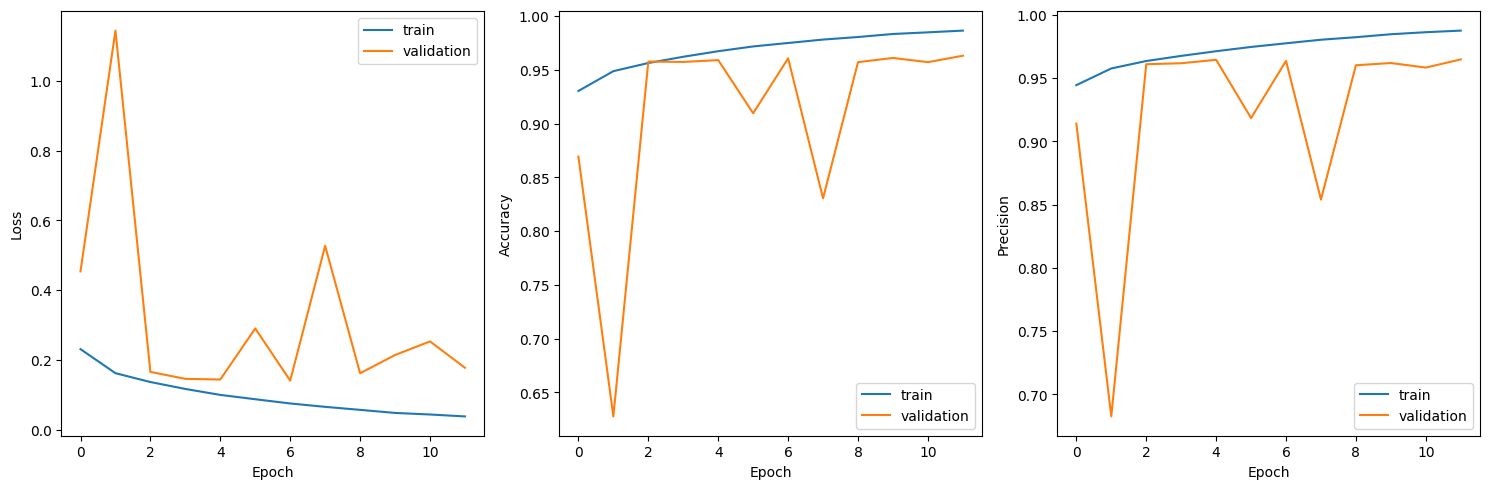

In [ ]:
fig, axs_smote = plt.subplots(1, 3, figsize=(15, 5))  # Crea una griglia di subplot 1x3

# Loss
axs_smote[0].plot(history_smote.history['loss'])
axs_smote[0].plot(history_smote.history['val_loss'])
axs_smote[0].set_xlabel('Epoch')
axs_smote[0].set_ylabel('Loss')
axs_smote[0].legend(['train', 'validation'])

# Accuracy
axs_smote[1].plot(history_smote.history['accuracy'])
axs_smote[1].plot(history_smote.history['val_accuracy'])
axs_smote[1].set_xlabel('Epoch')
axs_smote[1].set_ylabel('Accuracy')
axs_smote[1].legend(['train', 'validation'])

# Precision
axs_smote[2].plot(history_smote.history['precision'])
axs_smote[2].plot(history_smote.history['val_precision'])
axs_smote[2].set_xlabel('Epoch')
axs_smote[2].set_ylabel('Precision')
axs_smote[2].legend(['train', 'validation'])

plt.tight_layout()  # Per evitare sovrapposizioni di etichette o assi
plt.show()

The executed code utilizes the evaluate method of the Keras model to assess its performance using a test dataset.

In [ ]:
net_smote.evaluate(X_test,y_test)

811/811 [==============================] - 15s 19ms/step - loss: 0.1688 - accuracy: 0.9636 - precision: 0.9652


[0.16879643499851227, 0.9636496901512146, 0.9651589393615723]

The test set is used for generating predictions.

In [ ]:
y_pred_smote=net_smote.predict(X_test)

811/811 [==============================] - 15s 18ms/step


I am computing the precision, f1 and recall for each class.

In [ ]:
# Calcola la precisione per ogni classe
precision_per_classe_smote = precision_score(y_test.argmax(axis=1), y_pred_smote.argmax(axis=1), average=None)
f1_score_classe_smote= f1_score(y_test.argmax(axis=1), y_pred_smote.argmax(axis=1), average=None)
recall_classe_smote = recall_score(y_test.argmax(axis=1), y_pred_smote.argmax(axis=1), average=None)

print(table_score(nomi,precision_per_classe_smote,f1_score_classe_smote,recall_classe_smote))

Classe       Precisione    F1_score    Recall
---------  ------------  ----------  --------
Near-full       90.5512     89.914    89.2857
Center          94.1176     71.6418   57.8313
Edge-Loc        73.3978     75.6386   78.0206
none            99.1031     95.0538   91.3223
Loc             70.0624     66.0784   62.5232
Donut          100          95.4545   91.3043
Random          87.9699     88.9734   90
Edge-Ring       62.2951     31.6667   21.2291
Scratch         97.9236     98.5419   99.1679


In [ ]:
print(precision_score(y_test.argmax(axis=1), y_pred_smote.argmax(axis=1), average="macro"),
f1_score(y_test.argmax(axis=1), y_pred_smote.argmax(axis=1), average="macro"),
recall_score(y_test.argmax(axis=1), y_pred_smote.argmax(axis=1), average="macro"))

0.8615786790499966 0.7921811939321795 0.7563160625506056


The model chosen achieved the following results for precision, F1 score, and recall: 0.86, 0.79, and 0.75, respectively.

# **Reduce the complexity**

The code below is used to estimate a simpler model compared to the model previously used. Here is a summary of the code:

* The input shape is defined as (32, 32, 1), indicating that the model expects input images with dimensions of 32x32 pixels and a single channel (grayscale).
* The input tensor is defined as 'inputs_s'.
* Several layers are then applied to the input tensor:

 * Conv2D layer with 32 filters, a kernel size of 3x3, and 'same' padding.

 * BatchNormalization layer to normalize the activations of the previous layer.

 * Activation layer with the ReLU activation function.

 * MaxPooling2D layer with a pool size of 3x3 and 'same' padding.

 * GlobalMaxPooling2D layer to convert the 2D feature map into a 1D vector.

 * Finally, the output layer is defined as a Dense layer with 9 units and a softmax activation function, indicating a multiclass classification problem.

In [ ]:
# the input shape
inputs_s = keras.Input((32,32,1))

x_s = inputs_s
x_s = keras.layers.Conv2D(32, 3, padding="same")(x_s)
x_s = keras.layers.BatchNormalization()(x_s)
x_s = keras.layers.Activation("relu")(x_s)
x_s = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x_s)

x_s = keras.layers.GlobalMaxPooling2D()(x_s)

outputs_s = keras.layers.Dense(9, activation="softmax")(x_s)

In [ ]:
net_s = keras.Model(inputs_s, outputs_s)
# Compile the model for training
net_s.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy',tf.keras.metrics.Precision()])
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint_callback_s = keras.callbacks.ModelCheckpoint(filepath='gdrive/My Drive/Project FDL/S_model/weigth.{epoch:02d}.h5', save_weights_only=True, save_freq='epoch')
#Model Training
history_s = net_s.fit(X_train, y_train, epochs=20, validation_data=(X_val,y_val),batch_size=32 ,callbacks=[callback,checkpoint_callback_s], shuffle=True)
with open('gdrive/My Drive/Project FDL/S_model/history_s.pickle', 'wb') as file:
    pickle.dump(history_s, file)
net_s.save('gdrive/My Drive/Project FDL/S_model/net_s')

Epoch 1/20
3784/3784 [==============================] - 30s 5ms/step - loss: 0.3923 - accuracy: 0.8966 - precision: 0.9239 - val_loss: 0.3146 - val_accuracy: 0.9182 - val_precision: 0.9504
Epoch 2/20
3784/3784 [==============================] - 20s 5ms/step - loss: 0.2946 - accuracy: 0.9213 - precision: 0.9500 - val_loss: 0.2777 - val_accuracy: 0.9259 - val_precision: 0.9493
Epoch 3/20
3784/3784 [==============================] - 19s 5ms/step - loss: 0.2758 - accuracy: 0.9247 - precision: 0.9510 - val_loss: 0.2728 - val_accuracy: 0.9240 - val_precision: 0.9529
Epoch 4/20
3784/3784 [==============================] - 21s 5ms/step - loss: 0.2675 - accuracy: 0.9260 - precision: 0.9511 - val_loss: 0.2609 - val_accuracy: 0.9284 - val_precision: 0.9516
Epoch 5/20
3784/3784 [==============================] - 19s 5ms/step - loss: 0.2619 - accuracy: 0.9272 - precision: 0.9507 - val_loss: 0.2570 - val_accuracy: 0.9288 - val_precision: 0.9538
Epoch 6/20
3784/3784 [==============================] -

In [ ]:
#model.load_weights('gdrive/My Drive/Project FDL/S_model/weigth.{epoch:02d}.h5')  # Sostituisci <epoch> con il numero dell'ultima epoca completata
#num_epochs=  #deve essere uguale all'ultima epoch completata
#epo=    #deve essere uguale all'epoch dalla quale voglio riprendere l'addestramento
#model.fit(x_train, y_train, initial_epoch= epo, epochs=num_epochs, callbacks=[callback,checkpoint_callback_s])

In [ ]:
net_s=keras.models.load_model('gdrive/My Drive/Project FDL/S_model/net_s')
with open('gdrive/My Drive/Project FDL/S_model/history_s.pickle', 'rb') as file:
    history_s = pickle.load(file)

In [ ]:
net_s.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 32)       0         
 )                                                               
                                                                 
 global_max_pooling2d (Globa  (None, 32)               0     

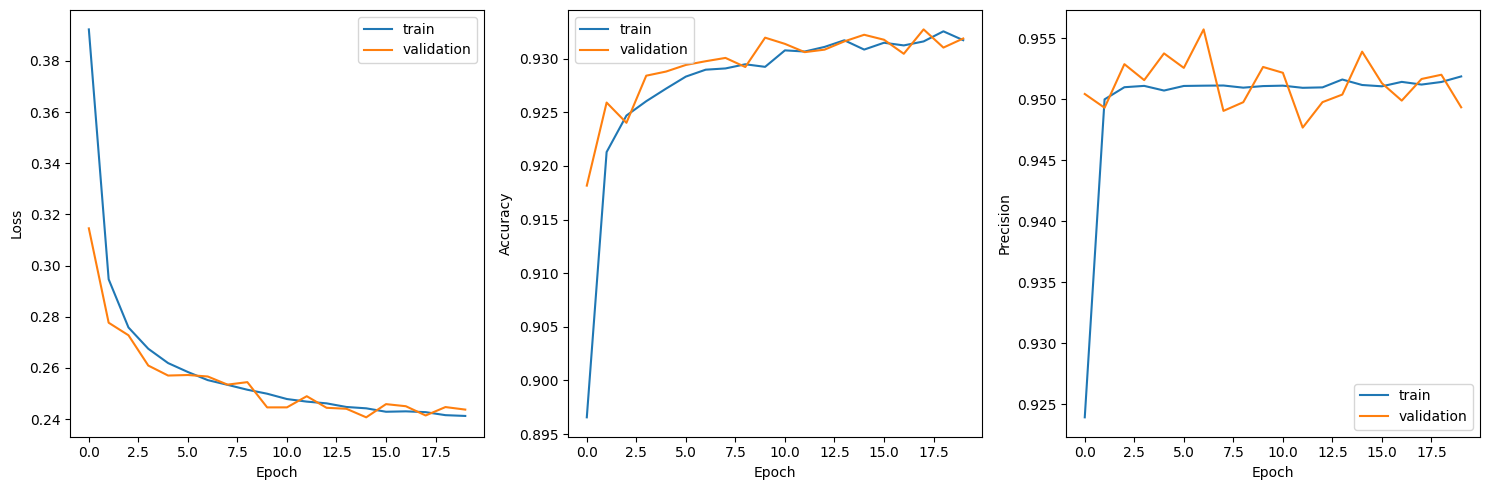

In [ ]:
fig, axs_s = plt.subplots(1, 3, figsize=(15, 5))  # Crea una griglia di subplot 1x3

# Loss
axs_s[0].plot(history_s.history['loss'])
axs_s[0].plot(history_s.history['val_loss'])
axs_s[0].set_xlabel('Epoch')
axs_s[0].set_ylabel('Loss')
axs_s[0].legend(['train', 'validation'])

# Accuracy
axs_s[1].plot(history_s.history['accuracy'])
axs_s[1].plot(history_s.history['val_accuracy'])
axs_s[1].set_xlabel('Epoch')
axs_s[1].set_ylabel('Accuracy')
axs_s[1].legend(['train', 'validation'])

# Precision
axs_s[2].plot(history_s.history['precision'])
axs_s[2].plot(history_s.history['val_precision'])
axs_s[2].set_xlabel('Epoch')
axs_s[2].set_ylabel('Precision')
axs_s[2].legend(['train', 'validation'])

plt.tight_layout()  # Per evitare sovrapposizioni di etichette o assi
plt.show()

The executed code utilizes the evaluate method of the Keras model to assess its performance using a test dataset.

In [ ]:
net_s.evaluate(X_test,y_test)

811/811 [==============================] - 7s 8ms/step - loss: 0.2373 - accuracy: 0.9338 - precision: 0.9508


[0.23727641999721527, 0.9338138699531555, 0.9507720470428467]

The test set is used for generating predictions.

In [ ]:
y_pred_s = net_s.predict(X_test)

811/811 [==============================] - 1s 2ms/step


I am computing the precision, f1 and recall for each class.

In [ ]:
# Calcola la precisione per ogni classe
precision_per_classe_s = precision_score(y_test.argmax(axis=1), y_pred_s.argmax(axis=1), average=None)
f1_score_classe_s= f1_score(y_test.argmax(axis=1), y_pred_s.argmax(axis=1), average=None)
recall_classe_s = recall_score(y_test.argmax(axis=1), y_pred_s.argmax(axis=1), average=None)

print(table_score(nomi,precision_per_classe_s, f1_score_classe_s, recall_classe_s))

Classe       Precisione    F1_score    Recall
---------  ------------  ----------  --------
Near-full       63.4146     67.7279   72.6708
Center          41.0959     38.4615   36.1446
Edge-Loc        61.4679     50.6425   43.0591
none            89.0269     88.9349   88.843
Loc             63.2812     24.2879   15.0278
Donut           80          28.5714   17.3913
Random          53.4031     63.5514   78.4615
Edge-Ring        0           0         0
Scratch         96.0636     97.5583   99.1001


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(precision_score(y_test.argmax(axis=1), y_pred_s.argmax(axis=1), average="macro"),
f1_score(y_test.argmax(axis=1), y_pred_s.argmax(axis=1), average="macro"),
recall_score(y_test.argmax(axis=1), y_pred_s.argmax(axis=1), average="macro"))

0.6086148542897012 0.5108174955048957 0.5007758629253085


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The model chosen achieved the following results for precision, F1 score, and recall: 0.608, 0.51 and 0.50, respectively.